In [2]:
import pandas as pd

# Read and preparing Data

In [3]:
data_series = pd.read_csv("/workspaces/BiciMad_4geeks_ML/data/interim/bicimad_time_series.csv", sep=',')

In [4]:
data_series['unlock_date'] = pd.to_datetime(data_series['unlock_date'], format='%Y-%m-%d')

In [5]:
data_series = data_series.set_index(data_series['unlock_date'])

# Time Series

Evaluareamos y predecidermos según cada dato de nuestro data_series, teniendo como índice la fecha de desbloqueo 'unlock_date'. Despues de estudiar y valorar todas las opciones univariantes y multivariantes como: Prophet, XGboost,SVR,... nos quedamos con : ***LSTM (multivariante)*** 

# LSTM

In [6]:
import numpy as np 
np.random.seed(42)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from statsmodels.tools.eval_measures import rmse 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
from keras.models import load_model
from keras import metrics
import warnings; 
warnings.simplefilter('ignore') 
from pickle import dump

2024-02-06 14:02:35.981326: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 14:02:36.106040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 14:02:36.106086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 14:02:36.107205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 14:02:36.140995: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-06 14:02:36.141831: I tensorflow/core/platform/cpu_feature_guard.cc:1

* Trip_minutes

In [7]:
data_series_LSTM = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'latitude_unlock', 'longitude_unlock', 'station_unlock',
       'dock_unlock',  'lock_date', 'lock_hour',
       'latitude_lock', 'longitude_lock', 'station_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [8]:
data_series_LSTM = data_series_LSTM.set_index(data_series_LSTM['unlock_date'])

In [9]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_min = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date', 'trip_minutes'])
y_train_min = data_series_LSTM[data_series_LSTM['unlock_date'] < '2022-10-01']['trip_minutes']
X_test_min = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date', 'trip_minutes'])
y_test_min = data_series_LSTM[data_series_LSTM['unlock_date'] >= '2022-10-01']['trip_minutes']

In [10]:
# Crear el modelo
model_LSTM_min = Sequential()

# Agregar capas al modelo
model_LSTM_min.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_min.add(Dropout(0.2))
model_LSTM_min.add(LSTM(50, return_sequences=False))
model_LSTM_min.add(Dropout(0.2))
model_LSTM_min.add(Dense(25))
model_LSTM_min.add(Dense(1))

In [11]:
# Crear la instancia de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_min.compile(optimizer='adam', loss='mean_squared_error')
# Entrenar el modelo
history = model_LSTM_min.fit(X_train_min, y_train_min, epochs=100, batch_size=1056, validation_split=0.2, callbacks=[early_stopping], verbose=0)

In [12]:
# Evaluar el modelo
train_loss = model_LSTM_min.evaluate(X_train_min, y_train_min, verbose=0)
test_loss = model_LSTM_min.evaluate(X_test_min, y_test_min, verbose=0)

print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

Train Loss: 5.63663911819458, Test Loss: 5.467356204986572


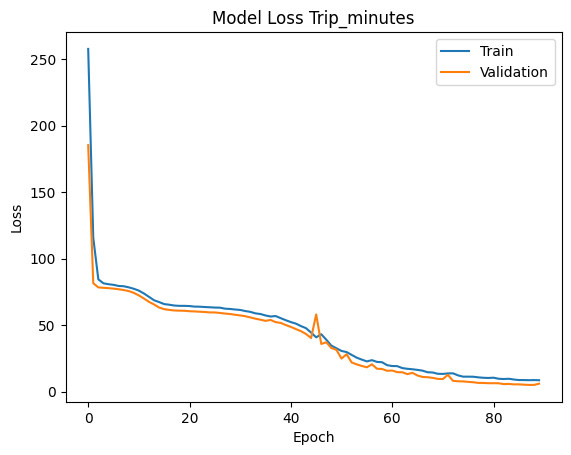

In [13]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Trip_minutes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [14]:
# Guardar el modelo
model_LSTM_min.save('model_LSTM_min.h5')

In [15]:
# Hago que el índice sea un DateTimeIndex
if not isinstance(data_series_LSTM.index, pd.DatetimeIndex):
    data_series_LSTM.index = pd.to_datetime(data_series_LSTM.index)

# Resamplea por mes y suma los valores de 'trip_minutes' para cada mes para evaluar el forecast
suma_trip_minutes_por_mes = data_series_LSTM['trip_minutes'].resample('M').sum()

In [51]:
def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

forecast_min = pd.DataFrame(multi_step_forecast(model_LSTM_min, suma_trip_minutes_por_mes, 12)) # Predice los próximos 12 meses

1/1 [==============================] - 0s 26ms/step


In [38]:
#Entendemos los datos conocidos para enfrentarlos a nuestra predicción
trips_by_month = data_series_LSTM['unlock_date'].resample('M').count()
trips_by_day = data_series_LSTM['unlock_date'].resample('D').count()

In [42]:
#Estableceramos esta media de trayectos por mes:
trips_by_month.mean()

2500.0833333333335

In [81]:
#Establecemos cuales serán los elementos del gráfico:
trips_2022_minutes = pd.DataFrame(suma_trip_minutes_por_mes)
trips_2022_minutes = trips_2022_minutes.reset_index(drop=True)
trips_2022_minutes = trips_2022_minutes.rename(columns={'trip_minutes': '0'})
prediction_minutes = forecast_min*trips_by_month.mean()

In [82]:
prediction_minutes

,0
0,83913.515625
1,107905.398438
2,112691.843750
3,113577.335938
4,113568.781250
5,113312.375000
6,113099.078125
7,112911.414062
8,112610.132812
9,112315.195312


* Distance

In [83]:
data_series_LSTM_dis = data_series.drop(columns=['idDriver', 'idBike',  'fleet', 
       'unlock_hour', 'station_unlock',
       'dock_unlock', 'lock_date', 'lock_hour',
       'latitude_lock', 'dock_lock', 'trip_day_of_week',
       'trip_duration_category', 'station_unlock_count', 'station_lock_count',
       'travel_direction', 'idDriver_n', 'unlock_station_name_n',
       'lock_station_name_n', 'lock_station_name', 'unlock_station_name'])

In [84]:
data_series_LSTM_dis = data_series_LSTM_dis.set_index(data_series_LSTM_dis['unlock_date'])

In [85]:
data_series_LSTM_dis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30001 entries, 2022-01-01 to 2022-12-31
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   trip_minutes              30001 non-null  float64       
 1   unlock_date               30001 non-null  datetime64[ns]
 2   latitude_unlock           30001 non-null  float64       
 3   longitude_unlock          30001 non-null  float64       
 4   longitude_lock            30001 non-null  float64       
 5   station_lock              30001 non-null  int64         
 6   distance                  30001 non-null  float64       
 7   trip_speed                30001 non-null  float64       
 8   trip_day_of_week_n        30001 non-null  int64         
 9   trip_duration_category_n  30001 non-null  int64         
 10  travel_direction_n        30001 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 2.7 MB

In [86]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date', 'distance'])
y_train_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] < '2022-10-01']['distance']
X_test_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date', 'distance'])
y_test_dis = data_series_LSTM_dis[data_series_LSTM_dis['unlock_date'] >= '2022-10-01']['distance']

In [88]:
# Crear el modelo
model_LSTM_dis = Sequential()

# Agregar capas al modelo
model_LSTM_dis.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_dis.add(Dropout(0.2))
model_LSTM_dis.add(LSTM(50, return_sequences=False))
model_LSTM_dis.add(Dropout(0.2))
model_LSTM_dis.add(Dense(25))
model_LSTM_dis.add(Dense(1))

In [89]:
# Crear la instancia de EarlyStopping
early_stopping_dis = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_dis.compile(optimizer='adam',loss='mean_squared_error')
# Entrenar el modelo
history_dis = model_LSTM_dis.fit(X_train_dis, y_train_dis, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dis], verbose=0)

In [91]:
# Evaluar el modelo
train_loss_dis = model_LSTM_dis.evaluate(X_train_dis, y_train_dis, verbose=0)
test_loss_dis = model_LSTM_dis.evaluate(X_test_dis, y_test_dis, verbose=0)

print(f'Train Loss: {train_loss_dis}, Test Loss: {test_loss_dis}')

Train Loss: 0.013589701615273952, Test Loss: 0.013008319772779942


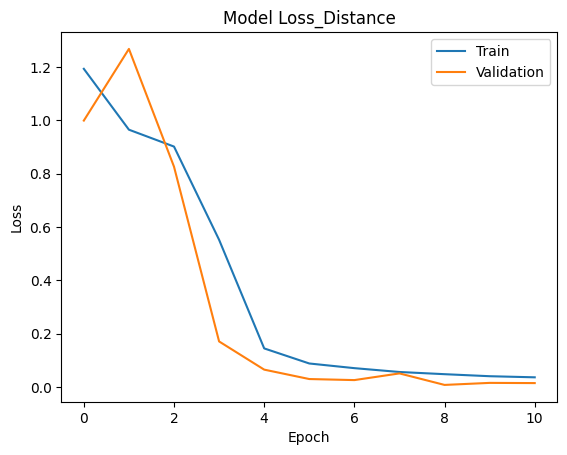

In [92]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history_dis.history['loss'])
plt.plot(history_dis.history['val_loss'])
plt.title('Model Loss_Distance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [93]:
# Guardar el modelo
model_LSTM_dis.save('model_LSTM_dis.h5')

In [94]:
# Hago que el índice sea un DateTimeIndex
if not isinstance(data_series_LSTM.index, pd.DatetimeIndex):
    data_series_LSTM_dis.index = pd.to_datetime(data_series_LSTM_dis.index)

# Resamplea por mes y suma los valores de 'trip_minutes' para cada mes para evaluar el forecast
suma_trip_distance_por_mes = data_series_LSTM_dis['distance'].resample('M').sum()

In [95]:
def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

forecast_dis = pd.DataFrame(multi_step_forecast(model_LSTM_dis, suma_trip_distance_por_mes, 12)) # Predice los próximos 12 meses

1/1 [==============================] - 0s 19ms/step


In [96]:
#Entendemos los datos conocidos para enfrentarlos a nuestra predicción
trips_by_month = data_series_LSTM['unlock_date'].resample('M').count()
trips_by_day = data_series_LSTM['unlock_date'].resample('D').count()

In [97]:
#Estableceramos esta media de trayectos por mes:
trips_by_month.mean()

2500.0833333333335

In [98]:
#Establecemos cuales serán los elementos del gráfico:
trips_2022_distance = pd.DataFrame(suma_trip_distance_por_mes)
trips_2022_distance = trips_2022_distance.reset_index(drop=True)
trips_2022_distance = trips_2022_distance.rename(columns={'trip_minutes': '0'})
prediction_distance = forecast_dis*trips_by_month.mean()

In [100]:
trips_2022_distance

,distance
0,3707.568721
1,4713.053562
2,4509.602060
3,4646.321854
4,8378.739048
5,7613.207540
6,6362.901834
7,4440.563449
8,7019.339966
9,6875.140210


* idBike

In [ ]:
data_series_bikes = pd.read_csv('/workspaces/BiciMad_4geeks_ML/data/processed/clean_data_trips.csv', sep=',')

: 

In [10]:
data_series_LSTM_bike = data_series_bikes.drop(columns=['idDriver', 'fleet', 
       'unlock_hour', 'address_unlock', 'address_lock', 'locktype', 'unlocktype',
       'dock_unlock', 'lock_date', 'lock_hour',
       'latitude_lock', 'dock_lock', 'lock_station_name', 'unlock_station_name'])

In [11]:
data_series_LSTM_bike = data_series_LSTM_bike.set_index(data_series_LSTM_bike['unlock_date'])

In [14]:
data_series_LSTM_bike.index.name = 'new_index_name'

In [18]:
data_series_LSTM_bike = data_series_LSTM_bike.groupby('unlock_date')['idBike'].nunique().reset_index(name='bikes_used')

In [26]:
data_series_LSTM_bike = data_series_LSTM_bike.set_index(data_series_LSTM_bike['unlock_date'])

In [47]:
data_series_LSTM_bike.head()

,unlock_date,bikes_used
unlock_date,,
2022-01-01,2022-01-01,1709
2022-01-02,2022-01-02,1817
2022-01-03,2022-01-03,2191
2022-01-04,2022-01-04,2011
2022-01-05,2022-01-05,1768


In [38]:
#Dividimos en train y test manualmente al ser una serie temporal
X_train_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] < '2022-10-01'].drop(columns=['unlock_date'])
y_train_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] < '2022-10-01']['bikes_used']
X_test_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] >= '2022-10-01'].drop(columns=['unlock_date'])
y_test_bike = data_series_LSTM_bike[data_series_LSTM_bike['unlock_date'] >= '2022-10-01']['bikes_used']

In [40]:
# Crear el modelo
model_LSTM_bike = Sequential()

# Agregar capas al modelo
model_LSTM_bike.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(None, 1)))
model_LSTM_bike.add(Dropout(0.2))
model_LSTM_bike.add(LSTM(50, return_sequences=False))
model_LSTM_bike.add(Dropout(0.2))
model_LSTM_bike.add(Dense(25))
model_LSTM_bike.add(Dense(1))

In [94]:
# Crear la instancia de EarlyStopping
early_stopping_bike = EarlyStopping(monitor='val_loss', patience=2)
# Compilar el modelo
model_LSTM_bike.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# Entrenar el modelo
history_bike = model_LSTM_bike.fit(X_train_bike, y_train_bike, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bike], verbose=0)

In [95]:
# Evaluar el modelo
train_loss_bike = model_LSTM_bike.evaluate(X_train_bike, y_train_bike, verbose=0)
test_loss_bike = model_LSTM_bike.evaluate(X_test_bike, y_test_bike, verbose=0)

print(f'Train Loss: {train_loss_bike}, Test Loss: {test_loss_bike}')

Train Loss: [112080.7265625, 0.0], Test Loss: [96804.7421875, 0.0]


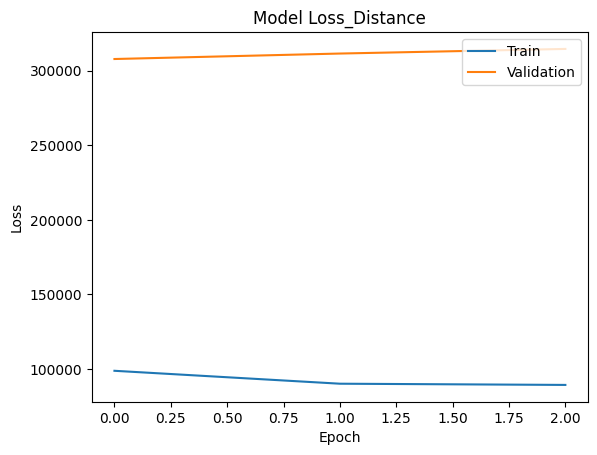

In [96]:
# Graficar la pérdida de entrenamiento y validación
plt.plot(history_bike.history['loss'])
plt.plot(history_bike.history['val_loss'])
plt.title('Model Loss_Distance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [44]:
# Guardar el modelo
model_LSTM_bike.save('model_LSTM_bike.h5')

In [74]:
data_series_LSTM_bike = data_series_LSTM_bike.drop(columns=['unlock_date'])

In [85]:
#Predecimos los meses futuros, para ello, agrupamos el dataset por meses para evaluar los datos y ser mas eficientes
data_series_bike = data_series_LSTM_bike.groupby(data_series_LSTM_bike.index.month).mean()

def multi_step_forecast(model, input_data, num_steps):
    x = input_data
    forecasts = []
    for _ in range(num_steps):
        yhat = model.predict(np.array([x]))[0, :] # Realiza la predicción
        forecasts.append(yhat) # Guarda la predicción
        x = np.roll(x, -1) # Desplaza la secuencia hacia adelante
        x[-1] = yhat # Añade la nueva predicción al final
    return np.array(forecasts)

# Suponiendo que 'model_LSTM_bike' ya está entrenado y ' data_series_bike['bikes_used']' contiene los datos de entrada
forecast = multi_step_forecast(model_LSTM_bike, data_series_bike['bikes_used'], 12) # Predice los próximos 12 meses
forecast

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


array([[1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542],
       [1577.1542]], dtype=float32)

In [86]:
data_series_bike

,bikes_used
unlock_date,
1,2238.322581
2,2501.142857
3,2314.774194
4,2353.800000
5,2638.064516
6,2663.766667
7,2488.548387
8,2081.774194
9,2492.733333


* Station_unlock

In [ ]:
# Suponiendo que 'data_series_LSTM_bike' es tu DataFrame
data_series_LSTM_bike_station_unlock = (
    data_series_LSTM_bike.groupby(['unlock_date', 'station_unlock'])['idBike']
    .nunique()
    .reset_index(name='bikes_used')
)


* Station_lock

In [ ]:
# Suponiendo que 'data_series_LSTM_bike' es tu DataFrame
data_series_LSTM_bike_station_lock = (
    data_series_LSTM_bike.groupby(['unlock_date', 'station_lock'])['idBike']
    .nunique()
    .reset_index(name='bikes_used')
)
